### Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

#### Some utilities functions

In [2]:
def save_model(model, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)


def load_model(filepath):
    return pickle.load(open(filepath, 'rb'))


def inverse_scale(arr, feature, df):
    scaler = MinMaxScaler(feature_range = (0,1), copy=True)
    scaler.fit_transform(df[feature].values.reshape(-1, 1))
    return scaler.inverse_transform(arr.reshape(-1, 1))


def plot_preds_actual(preds, actual, title):
    fig, ax = plt.subplots(figsize=(20,8))
    ax.plot(actual, label='Target')
    ax.plot(preds, label='Prediction')
    ax.set_ylabel('pm2.5', fontsize=16)
    ax.set_xlabel('Time step', fontsize=16)
    ax.set_title(title)
    ax.legend()
    plt.show()

### Read the dataset

In [3]:
train_raw = pd.read_csv('final_data/train_df_ssa.csv')
test_raw = pd.read_csv('final_data/test_df.csv')

### Scale dataset using Minmaxscaler

In [4]:
def data_scaler(df):
    scaler = MinMaxScaler(feature_range = (0,1), copy=True)
    station = df.copy()
    scaled = scaler.fit_transform(station[station.columns[:14]])
    scaled = pd.DataFrame(scaled, columns=station.columns[:14],index = station.index)
    for feature in scaled.columns:
        station[feature] = scaled[feature]
    return station

In [5]:
train_scaled = data_scaler(train_raw)
test_scaled = data_scaler(test_raw)
train_scaled.head()

,pm,CH4,CO,Humid,Nitrogen_oxide,NO,NO2,non_methane_hydrocarbons,oxidant,SO2,...,wind_direct_8.0,wind_direct_9.0,wind_direct_10.0,wind_direct_11.0,wind_direct_12.0,wind_direct_13.0,wind_direct_14.0,wind_direct_15.0,wind_direct_16.0,wind_direct_17.0
0,0.122934,0.233645,0.176471,0.8875,0.122807,0.0,0.162791,0.112245,0.108108,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.142559,0.242991,0.117647,0.8875,0.087719,0.0,0.116279,0.112245,0.099099,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.157490,0.271028,0.117647,0.9000,0.087719,0.0,0.116279,0.122449,0.153153,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.159084,0.355140,0.117647,0.9500,0.122807,0.0,0.162791,0.142857,0.162162,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.158103,0.355140,0.117647,0.9375,0.122807,0.0,0.162791,0.153061,0.207207,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Convert the dataset into a supervised dataset in which features from previous time steps are used to predict the PM value of the current time step

In [6]:
# convert series to supervised learning
def series_to_supervised(data, target_var, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data.copy()
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{var}(t-{i})' for var in df.columns]
    # forecast sequence (t, t+1)
    for i in range(0, n_out):
        cols.append(df.shift(-i)[target_var])
        if i == 0:
            names += [f'{target_var}(t)']
        else:
            names += [f'{target_var}(t+{i})']
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Use only the last time step to predict

In [7]:
num_time_step = 1
train = series_to_supervised(train_scaled, "pm", num_time_step)
test = series_to_supervised(test_scaled, 'pm', num_time_step)
train.head()

,pm(t-1),CH4(t-1),CO(t-1),Humid(t-1),Nitrogen_oxide(t-1),NO(t-1),NO2(t-1),non_methane_hydrocarbons(t-1),oxidant(t-1),SO2(t-1),...,wind_direct_9.0(t-1),wind_direct_10.0(t-1),wind_direct_11.0(t-1),wind_direct_12.0(t-1),wind_direct_13.0(t-1),wind_direct_14.0(t-1),wind_direct_15.0(t-1),wind_direct_16.0(t-1),wind_direct_17.0(t-1),pm(t)
1,0.122934,0.233645,0.176471,0.8875,0.122807,0.0,0.162791,0.112245,0.108108,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142559
2,0.142559,0.242991,0.117647,0.8875,0.087719,0.0,0.116279,0.112245,0.099099,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157490
3,0.157490,0.271028,0.117647,0.9000,0.087719,0.0,0.116279,0.122449,0.153153,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.159084
4,0.159084,0.355140,0.117647,0.9500,0.122807,0.0,0.162791,0.142857,0.162162,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.158103
5,0.158103,0.355140,0.117647,0.9375,0.122807,0.0,0.162791,0.153061,0.207207,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.175354


### Seperate the dataset into train features and predict feature

In [8]:
train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
train_y.head()

1    0.142559
2    0.157490
3    0.159084
4    0.158103
5    0.175354
Name: pm(t), dtype: float64

### Train SVR

In [11]:
# find the optimal hyperparameters
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.01, 0.0001],
    'epsilon': [0.01, 0.1],
    'kernel': ['rbf']
}

# create a grid search object
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 4, n_jobs=-1, scoring="neg_root_mean_squared_error")

# train the model
grid.fit(train_X, train_y)

# save the model if desired
save_model(grid, "1_step_ssa.model")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 3/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.023 total time=  37.6s
[CV 4/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.036 total time=  40.9s
[CV 2/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.031 total time=  40.9s
[CV 1/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.032 total time=  42.8s
[CV 5/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.027 total time=  39.5s
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.038 total time=  39.5s
[CV 2/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.034 total time=  40.1s
[CV 3/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.027 total time=  38.4s
[CV 4/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.037 total time=  32.1s
[CV 5/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.031 total time=  33.4s
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.00

In [12]:
grid.best_estimator_

SVR(C=10, epsilon=0.01, gamma=0.01)

### See how well the model fit the dataset

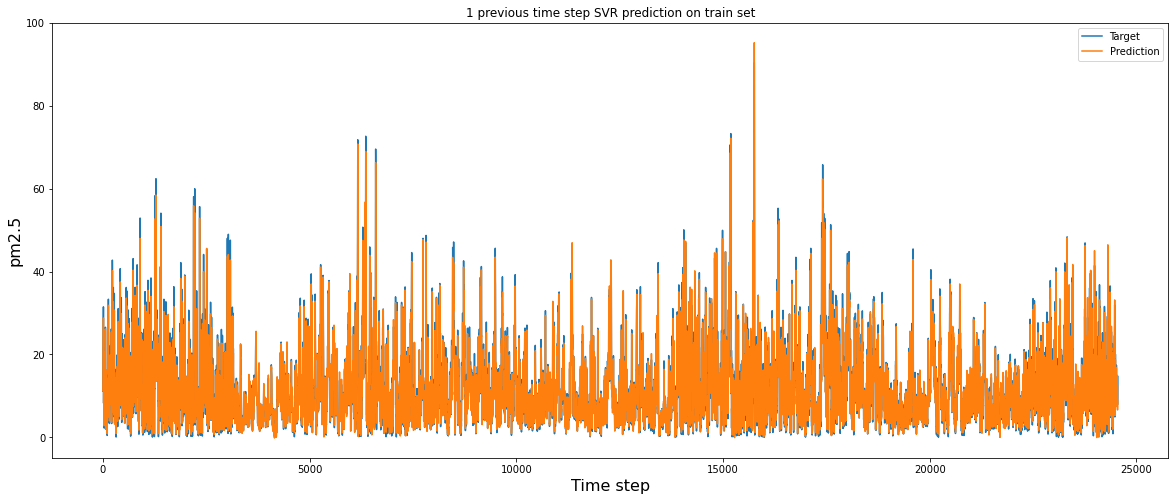

In [9]:
# load the model saved model if trained already
grid = load_model("1_step_ssa.model")

train_pred = grid.predict(train_X)
train_pred = inverse_scale(train_pred, "pm", train_raw)
plot_preds_actual(train_pred, train_raw['pm'], "1 previous time step SVR prediction on train set")

### Now plot the prediction on test set

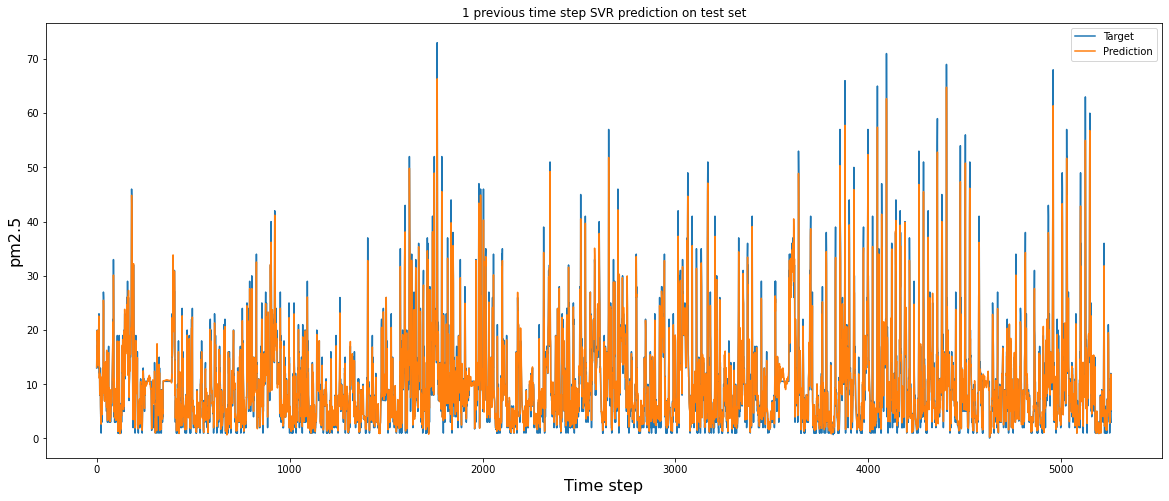

In [10]:
test_pred = grid.predict(test_X)
test_pred_rescale = inverse_scale(test_pred, "pm", test_raw)
plot_preds_actual(test_pred_rescale, test_raw['pm'], "1 previous time step SVR prediction on test set")

#### Errors on the test set

In [11]:
print("MSE: {}".format(mean_squared_error(test_raw["pm"][1:], test_pred_rescale)))
print("MAE: {}".format(mean_absolute_error(test_raw["pm"][1:], test_pred_rescale)))
print("r^2: {}".format(r2_score(test_raw["pm"][1:], test_pred_rescale)))

MSE: 38.19111451188525
MAE: 3.9498093362608007
r^2: 0.5300855843849958


### Experiment with using more time steps to predict

#### 3 previous time steps

##### Training phase

In [12]:
# change number of time step to 3 then set up training data normally
num_time_step = 3
train = series_to_supervised(train_scaled, "pm", num_time_step)
test = series_to_supervised(test_scaled, 'pm', num_time_step)

train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

In [17]:
# find the optimal hyperparameters
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.01, 0.0001],
    'epsilon': [0.01, 0.1],
    'kernel': ['rbf']
} 

# create a grid search object
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 4, n_jobs=-1, scoring="neg_root_mean_squared_error")

# train the model
grid.fit(train_X, train_y)

# save the model if desired
save_model(grid, "3_step_ssa.model")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 4/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.087 total time= 2.8min
[CV 2/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.078 total time= 2.8min
[CV 3/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.058 total time= 2.9min
[CV 1/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.068 total time= 3.3min
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.047 total time= 1.3min
[CV 2/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.043 total time= 1.3min
[CV 3/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.035 total time= 1.3min
[CV 4/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.047 total time= 1.2min
[CV 5/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.037 total time= 1.2min
[CV 5/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.057 total time= 2.7min
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.00

##### Plot train set prediction

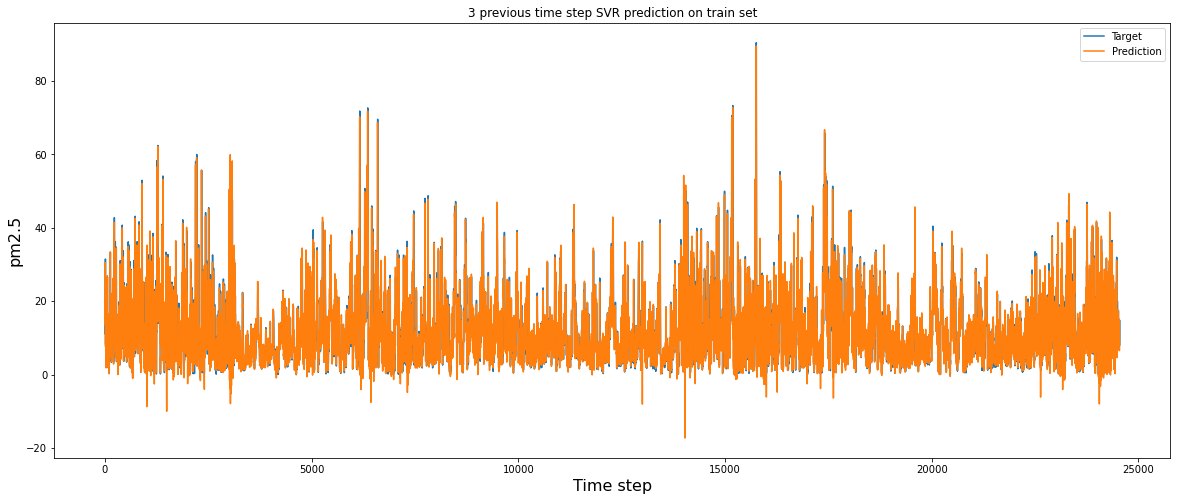

In [13]:
# load saved model
grid = load_model("3_step_ssa.model")

train_pred = grid.predict(train_X)
train_pred = inverse_scale(train_pred, "pm", train_raw)
plot_preds_actual(train_pred, train_raw['pm'], "3 previous time step SVR prediction on train set")

##### Plot test set prediction

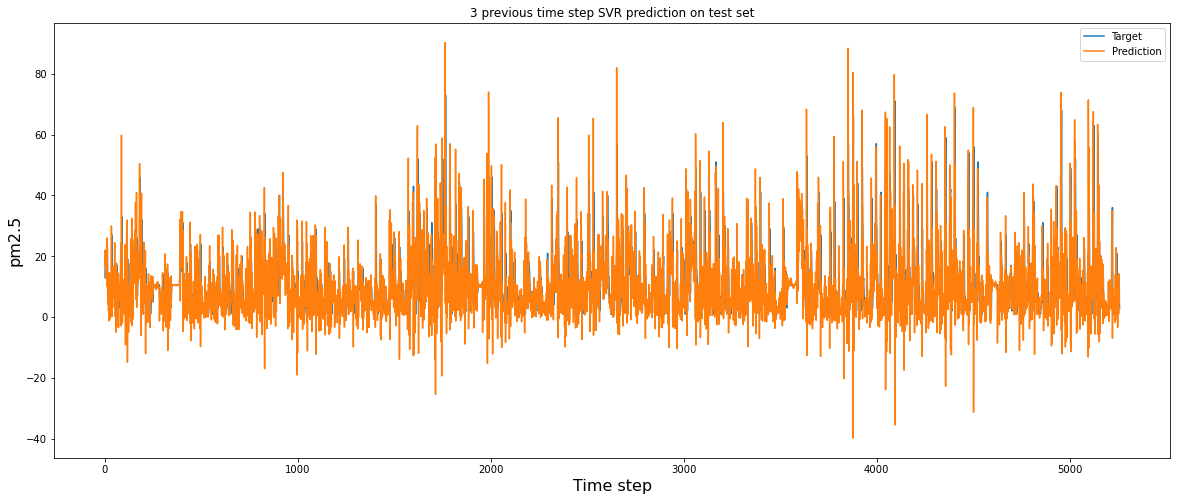

In [14]:
test_pred = grid.predict(test_X)
test_pred_rescale = inverse_scale(test_pred, "pm", test_raw)
plot_preds_actual(test_pred_rescale, test_raw['pm'], "3 previous time step SVR prediction on test set")

In [15]:
print("MSE: {}".format(mean_squared_error(test_raw["pm"][3:], test_pred_rescale)))
print("MAE: {}".format(mean_absolute_error(test_raw["pm"][3:], test_pred_rescale)))
print("r^2: {}".format(r2_score(test_raw["pm"][3:], test_pred_rescale)))

MSE: 73.50180265604513
MAE: 5.638229276310708
r^2: 0.0957801586684871


In [21]:
grid.best_estimator_

SVR(C=10, epsilon=0.01, gamma=0.01)

#### 5 previous time steps

##### Training phase

In [22]:
# change number of time step to 5 then set up training data normally
num_time_step = 5
train = series_to_supervised(train_scaled, "pm", num_time_step)
test = series_to_supervised(test_scaled, 'pm', num_time_step)

train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

In [23]:
# find the optimal hyperparameters
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.01, 0.0001],
    'epsilon': [0.01, 0.1],
    'kernel': ['rbf']
} 

# create a grid search object
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 4, n_jobs=-1, scoring="neg_root_mean_squared_error")

# train the model
grid.fit(train_X, train_y)

# save the model if desired
save_model(grid, "5_step_ssa.model")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 4/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.106 total time= 6.0min
[CV 3/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.077 total time= 6.0min
[CV 2/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.099 total time= 6.0min
[CV 1/5] END C=0.1, epsilon=0.01, gamma=1, kernel=rbf;, score=-0.084 total time= 7.1min
[CV 2/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.053 total time= 2.0min
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.056 total time= 2.0min
[CV 3/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.043 total time= 2.0min
[CV 5/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.044 total time= 2.0min
[CV 4/5] END C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf;, score=-0.056 total time= 2.0min
[CV 1/5] END C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf;, score=-0.081 total time= 2.3min
[CV 5/5] END C=0.1, epsilon=0.01, gamma

##### Plot train set prediction

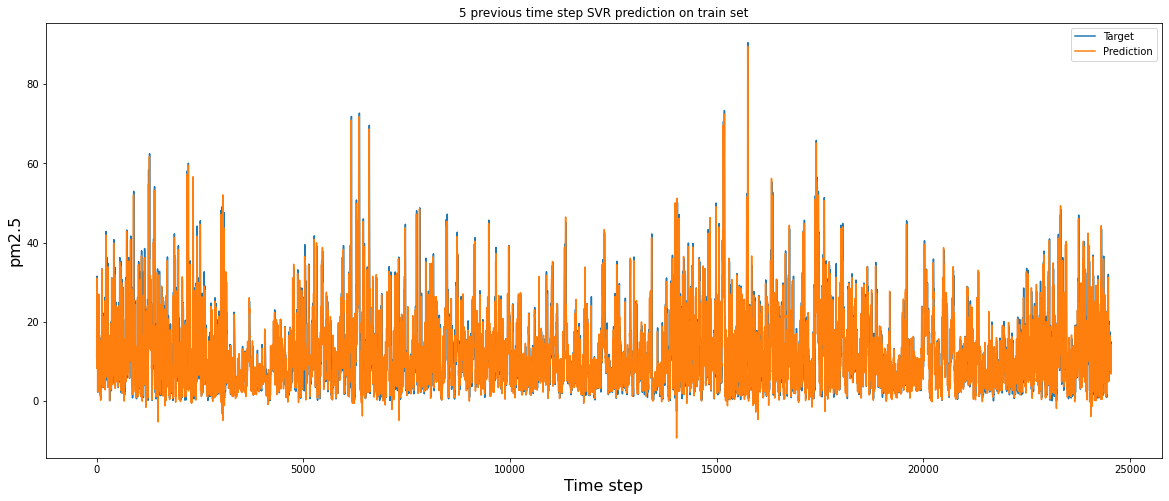

In [24]:
# load saved model
grid = load_model("5_step_ssa.model")

train_pred = grid.predict(train_X)
train_pred = inverse_scale(train_pred, "pm", train_raw)
plot_preds_actual(train_pred, train_raw['pm'], "5 previous time step SVR prediction on train set")

##### Plot test set prediction

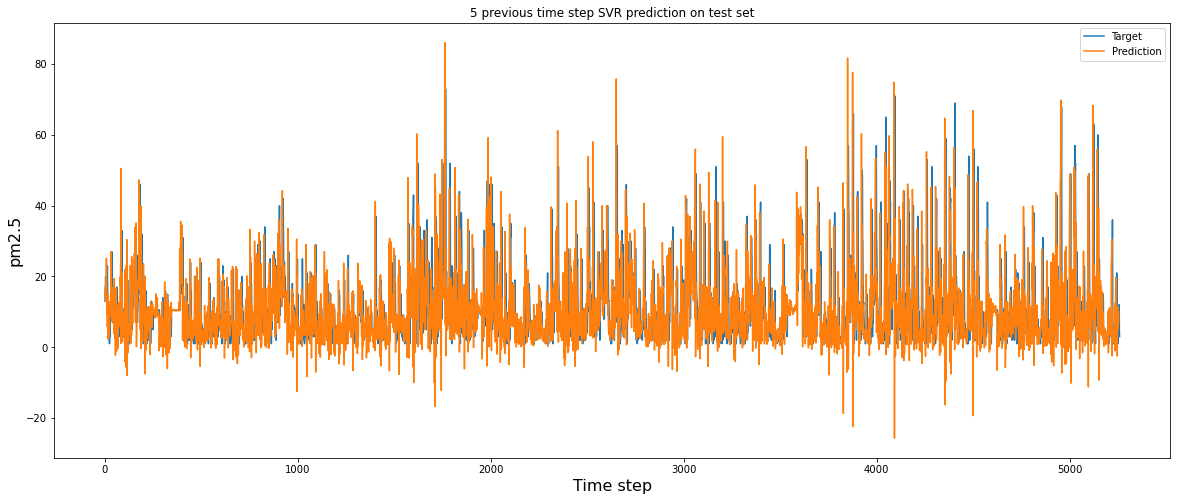

In [25]:
test_pred = grid.predict(test_X)
test_pred_rescale = inverse_scale(test_pred, "pm", test_raw)
plot_preds_actual(test_pred_rescale, test_raw['pm'], "5 previous time step SVR prediction on test set")

In [26]:
print("MSE: {}".format(mean_squared_error(test_raw["pm"][5:], test_pred_rescale)))
print("MAE: {}".format(mean_absolute_error(test_raw["pm"][5:], test_pred_rescale)))
print("r^2: {}".format(r2_score(test_raw["pm"][5:], test_pred_rescale)))

MSE: 52.94391092175643
MAE: 4.811331543898128
r^2: 0.3487099904012887


In [27]:
grid.best_estimator_

SVR(C=10, epsilon=0.01, gamma=0.01)